# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs. <br>
The goal is to develop a model that could potentially *help employees estimate their worth* and *employers plan their expense* in a market that is sometimes intransparent in regards to salary.

In [1]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Optional, List, Union
import shap



In [2]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [3]:
# Load data

df_raw = pd.read_csv('data/survey_results_public.csv')
df_raw.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


----------------------------

--------------------

## 1. Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary
`ConvertedCompYearly`

In [4]:
df_eda = df_raw.copy()

In [5]:
df_eda['Country'].value_counts()[:20]

Country
United States of America                                11095
Germany                                                  4947
India                                                    4231
United Kingdom of Great Britain and Northern Ireland     3224
Ukraine                                                  2672
France                                                   2110
Canada                                                   2104
Poland                                                   1534
Netherlands                                              1449
Brazil                                                   1375
Italy                                                    1341
Australia                                                1260
Spain                                                    1123
Sweden                                                   1016
Russian Federation                                        925
Switzerland                                               876


In [8]:
df_eda = df_eda[df_eda['Country'].isin(['Germany', 'United Kingdom of Great Britain and Northern Ireland', 'France', 'Netherlands', 'Austria'])]
df_eda.shape

(12521, 114)

In [9]:
# some simple descriptive statistics
print(f'Rows without salary information {df_eda.ConvertedCompYearly.isna().sum()}')
df_eda.ConvertedCompYearly.describe()

Rows without salary information 7261


count    5.260000e+03
mean     8.166933e+04
std      6.586133e+04
min      1.000000e+00
25%      5.155500e+04
50%      7.006300e+04
75%      9.666600e+04
max      1.288874e+06
Name: ConvertedCompYearly, dtype: float64

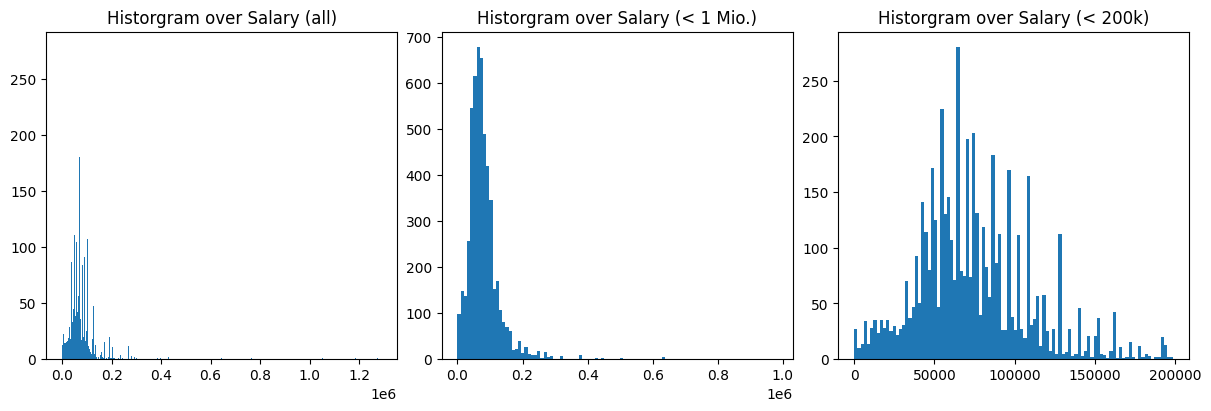

In [10]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df_eda.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')

plt.show()

*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


In [13]:
# Exploring Features only on rows with salary!
df_eda = df_eda[df_eda.ConvertedCompYearly.notna()]
df_eda.shape

(5260, 114)

In [14]:
print(df_eda[df_eda.ConvertedCompYearly < 500].ConvertedCompYearly.value_counts())
# salary < 500$ seems unrealistic for a full time job even in low income countries --> exclude
# extremly high salaries might have high impect and be influential in leafs
df_eda = df_eda[(df_eda['ConvertedCompYearly'] > 500) & (df_eda['ConvertedCompYearly'] < 500000)]
df_eda.shape

ConvertedCompYearly
1.0      3
12.0     1
26.0     1
97.0     1
178.0    1
322.0    1
38.0     1
43.0     1
73.0     1
76.0     1
Name: count, dtype: int64


(5229, 114)

------------------------------------------------------------------------------------------------------------------------------

#### Potential features examination

To keep the model relatively simple, interpretable and usable for prediction features will only include the first two sections of the survey (1. Basic Information & 2 - Education + Work + Career.) <br>
Additionally questions `BuyNewTool`, `BuildvsBuy`, `TechEndorse` will be excluded for two main reasons:
1. No logical reason why they should influence salary
2. And more importantly, not really applicable when trying to predict an appropriate salary

`Currency` will be excluded as Salary in target is converted already and besides conversion, currency mostly represents duplicate information with country.

`LearnCodeOnline` will be excluded as it is clearly secondary information to `LearnCode`.

`TechDoc` will be excluded. This might indirectly represent a devs abilities or style of work but seems like in theory it should not *directly* influence salary.


In [15]:
# make sure to only include those that passed the check of attention in survey
# --> only those who pass can continue the survey so 100% pass in data
df_eda.Check.describe()

count       5229
unique         1
top       Apples
freq        5229
Name: Check, dtype: object

##### `MainBranch` & `Emplyoment`
Technically we only care about those who work as some sort of dev professionally as we want to determine what influences salary of a dev. For comparibility we stick to full time emplyoment.

In [16]:
# filter to keep only those working as some sort of dev professionally and being employed full time
df_eda = df_eda[
    (df_eda['MainBranch'] == "I am a developer by profession") &
    (df_eda['Employment'].str.contains("Employed, full-time", na=False))
]

df_eda.shape

(3974, 114)

In [17]:
# preselection of features
df_eda = df_eda[['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'PurchaseInfluence', 'Country', 'ConvertedCompYearly']]

df_eda.shape

(3974, 12)

In [18]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3974 entries, 392 to 41162
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  3974 non-null   object 
 1   RemoteWork           3974 non-null   object 
 2   CodingActivities     3974 non-null   object 
 3   EdLevel              3974 non-null   object 
 4   LearnCode            3963 non-null   object 
 5   YearsCode            3965 non-null   object 
 6   YearsCodePro         3962 non-null   object 
 7   DevType              3967 non-null   object 
 8   OrgSize              3970 non-null   object 
 9   PurchaseInfluence    3969 non-null   object 
 10  Country              3974 non-null   object 
 11  ConvertedCompYearly  3974 non-null   float64
dtypes: float64(1), object(11)
memory usage: 403.6+ KB


##### `YearsCode` & `YearsCodePro`

Apart from our target all columns (features) are of datatype object. <br>
`YearsCode` & `YearsCodePro` could technically be numerical. So lets check them:

In [19]:
df_eda.YearsCode.unique()
df_eda.YearsCode.value_counts()

YearsCode
10                    377
8                     250
15                    239
12                    227
20                    216
7                     209
6                     178
9                     169
11                    162
14                    155
25                    141
13                    140
16                    130
5                     124
18                    118
4                      98
30                     96
17                     94
24                     72
22                     68
40                     66
19                     57
23                     52
26                     48
35                     48
27                     48
21                     42
3                      41
28                     40
2                      23
32                     21
34                     21
38                     20
42                     19
29                     18
45                     17
36                     14
43                     14
33

In [20]:
df_eda.YearsCodePro.value_counts()

YearsCodePro
5                   319
3                   291
6                   277
10                  260
4                   257
7                   255
2                   249
8                   237
12                  162
15                  136
9                   135
11                  130
1                   128
20                  108
Less than 1 year     93
13                   91
14                   88
16                   79
25                   76
17                   69
18                   69
23                   48
24                   42
19                   41
21                   39
30                   36
22                   35
28                   33
26                   29
27                   25
40                   16
35                   16
32                   14
29                   13
31                   10
33                    9
37                    8
39                    7
38                    7
45                    6
34                    6
36 

We can clearly see that the format of the question allowed for or explictly offered answers that cannot be converted to float or integer. <br>
These values make up only a fraction of the dataset but represent edge cases (<1 year and > 50 years). 

We have the option to exclude these values and convert the rest to integer or replace these values with an adequate integer. <br>
To ensure that the model applies to people with very little or very much coding experience as well I am going to keep the edge cases and convert them to the next integer (i.e. < 1year &rarr; 0 and >50 &rarr; 51). <br>
Furthermore I am going to treat years as continious variables.

In [21]:
# replace values

df_eda.replace(
    {'More than 50 years': '51', 'Less than 1 year': '0'}, inplace=True
)

# convert to int

# Convert the two columns to integers
df_eda['YearsCode'] = pd.to_numeric(df_eda['YearsCode'], errors='coerce').fillna(0).astype(int)
df_eda['YearsCodePro'] = pd.to_numeric(df_eda['YearsCodePro'], errors='coerce').fillna(0).astype(int)

# check if it worked
df_eda.info()

print(df_eda.YearsCode.value_counts())
 
print(df_eda.YearsCodePro.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 3974 entries, 392 to 41162
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  3974 non-null   object 
 1   RemoteWork           3974 non-null   object 
 2   CodingActivities     3974 non-null   object 
 3   EdLevel              3974 non-null   object 
 4   LearnCode            3963 non-null   object 
 5   YearsCode            3974 non-null   int64  
 6   YearsCodePro         3974 non-null   int64  
 7   DevType              3967 non-null   object 
 8   OrgSize              3970 non-null   object 
 9   PurchaseInfluence    3969 non-null   object 
 10  Country              3974 non-null   object 
 11  ConvertedCompYearly  3974 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 403.6+ KB
YearsCode
10    377
8     250
15    239
12    227
20    216
7     209
6     178
9     169
11    162
14    155
25    141
13    140
1

array([[<Axes: xlabel='YearsCode', ylabel='YearsCode'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCode'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCode'>],
       [<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCodePro'>],
       [<Axes: xlabel='YearsCode', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='YearsCodePro', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='ConvertedCompYearly'>]],
      dtype=object)

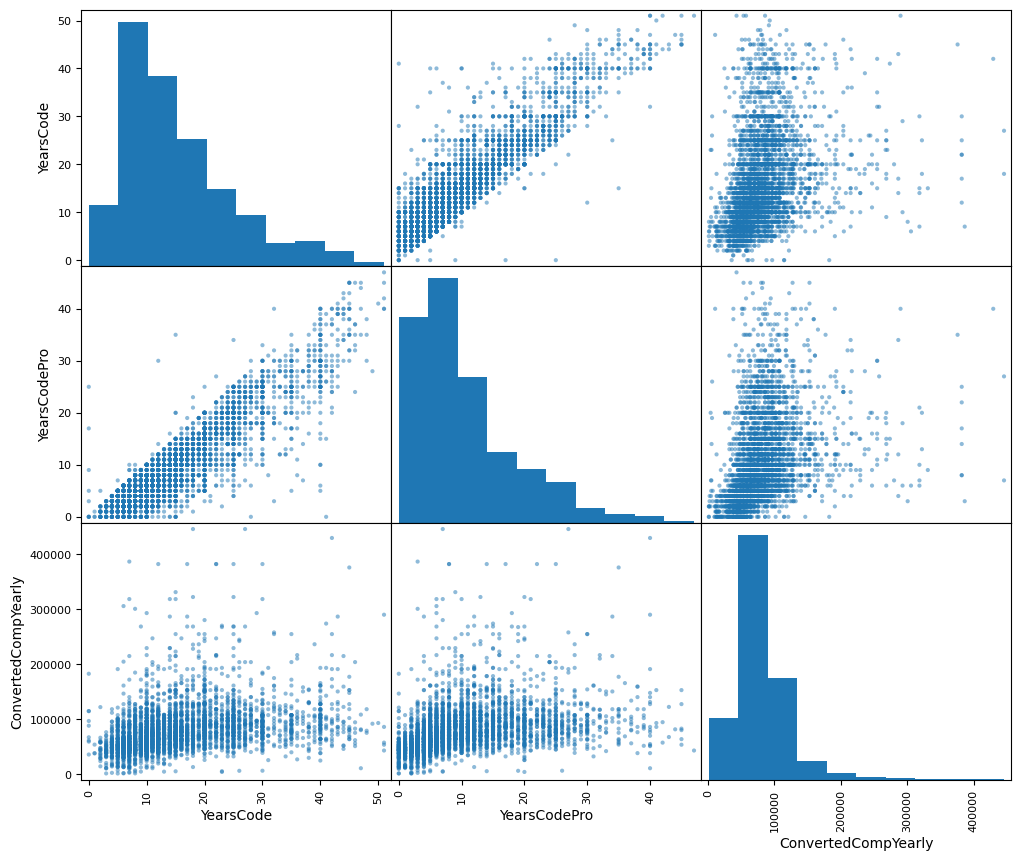

In [22]:
scatter_matrix(df_eda[['YearsCode', 'YearsCodePro', 'ConvertedCompYearly']], figsize=(12, 10))

We can see that both `YearsCode` and `YearsCodePro`have a right skewed distribution. <br>

These two variables are clearly correlated &rarr; potentially colinearity <br>

No clear relationship visible between `YearsCode` and `YearsCodePro` and our target. But might at least partially be obscured by the outliers <br>

In [23]:
# check categorical features for imbalance
cat_features = ['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly']

for f in cat_features:
    print(f'{f}:')
    
    print(df_eda[f].value_counts())

Age:
Age
25-34 years old       1890
35-44 years old       1110
18-24 years old        452
45-54 years old        378
55-64 years old        129
65 years or older       12
Under 18 years old       2
Prefer not to say        1
Name: count, dtype: int64
RemoteWork:
RemoteWork
Hybrid (some remote, some in-person)    2317
Remote                                  1126
In-person                                531
Name: count, dtype: int64
CodingActivities:
CodingActivities
Hobby                                                                                                                                          1013
I don’t code outside of work                                                                                                                    531
Hobby;Professional development or self-paced learning from online courses                                                                       509
Hobby;Contribute to open-source projects                                              

##### `CodingActivities`

In [24]:
# For simplicity and essentially interpretability of the model we will only distinguish between those that code outside of work and those who don't
# The number pf possible combination of coding activities outside of work would make the model very hard to interpret
# print(df_eda['CodingActivities'].unique())

# 0 = dont code outside of work
df_eda['CodingOutsideOfWork'] = 1
df_eda.loc[df_eda['CodingActivities'].str.contains("I don’t code outside of work", na=False), 'CodingOutsideOfWork'] = 0
df_eda.drop(['CodingActivities'], axis=1, inplace=True)
df_eda.CodingOutsideOfWork.value_counts()

CodingOutsideOfWork
1    3443
0     531
Name: count, dtype: int64

##### `LearnCode`

In [25]:
# For the same reason (interpretability) we will only include one dummy / boolean for each learning type instead of including each possible combination of learning experiences as dummies

df_eda['LC_PhysicalMedia'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Books / Physical media', na=False), 'LC_PhysicalMedia'] = 1
print(df_eda.LC_PhysicalMedia.value_counts())

df_eda['LC_Bootcamp'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Coding Bootcamp', na=False), 'LC_Bootcamp'] = 1
print(df_eda.LC_Bootcamp.value_counts())


df_eda['LC_Colleague'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Colleague', na=False), 'LC_Colleague'] = 1
print(df_eda.LC_Colleague.value_counts())


df_eda['LC_FriendFamily'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Friend or family member', na=False), 'LC_FriendFamily'] = 1
print(df_eda.LC_FriendFamily.value_counts())


df_eda['LC_Online'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Online Courses or Certification', na=False), 'LC_Online'] = 1
print(df_eda.LC_Online.value_counts())


df_eda['LC_Job'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('On the job training', na=False), 'LC_Job'] = 1
print(df_eda.LC_Job.value_counts())


df_eda['LC_OnlineOther'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('Other online resources', na=False), 'LC_OnlineOther'] = 1
print(df_eda.LC_OnlineOther.value_counts())


df_eda['LC_School'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('School', na=False), 'LC_School'] = 1
print(df_eda.LC_School.value_counts())

df_eda.drop(['LearnCode'], axis=1, inplace=True)



LC_PhysicalMedia
0    2006
1    1968
Name: count, dtype: int64
LC_Bootcamp
0    3730
1     244
Name: count, dtype: int64
LC_Colleague
0    2792
1    1182
Name: count, dtype: int64
LC_FriendFamily
0    3619
1     355
Name: count, dtype: int64
LC_Online
0    2253
1    1721
Name: count, dtype: int64
LC_Job
1    2230
0    1744
Name: count, dtype: int64
LC_OnlineOther
1    3247
0     727
Name: count, dtype: int64
LC_School
0    1996
1    1978
Name: count, dtype: int64


##### `Age`

*Unfortunately* age is available only in categories. we can treat it as ordinal and encode with `OrdinalEncoder`to keep as much information as possible. <br>

*'I prefer no to say'* will be treated as missing value.

In [26]:
df_eda.replace(
    {'Prefer not to say': np.nan}, inplace=True
)
df_eda.Age.unique()

array(['35-44 years old', '45-54 years old', '25-34 years old',
       '55-64 years old', '18-24 years old', 'Under 18 years old',
       '65 years or older', nan], dtype=object)

##### `Countries`


In [27]:
df_eda['Country'].value_counts()

Country
Germany                                                 1478
United Kingdom of Great Britain and Northern Ireland    1137
France                                                   723
Netherlands                                              420
Austria                                                  216
Name: count, dtype: int64

As a first remedy for the large number of countries with sparse data we will use `frequency encoding`, making the **Assumption**  the frequency of the Country in this data is not due to some sampling bias but rather a reflection of economic factors. 

##### `RemoteWork`

Could be considered ordinal &rarr; `Ordinal Encoding`

In [28]:
df_eda['RemoteWork'].value_counts()

RemoteWork
Hybrid (some remote, some in-person)    2317
Remote                                  1126
In-person                                531
Name: count, dtype: int64

##### `EdLevel`

While there is some order of education level this does not hold true for all categories (different types rather than different level), therefore we ordinal encoding is not an option and we have to stick to `one-hot encoding`


In [29]:
df_eda['EdLevel'].value_counts()

EdLevel
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       1535
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          1357
Some college/university study without earning a degree                                 420
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     259
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         233
Associate degree (A.A., A.S., etc.)                                                    105
Something else                                                                          60
Primary/elementary school                                                                5
Name: count, dtype: int64

##### `DevType`

'Other' will be treated as as other together with those jobs with less than 30 occurences. 30 is somewhat arbitrary and definely up for debate.

In [30]:
counts = df_eda['DevType'].value_counts()

df_eda['DT'] = df_eda['DevType'].apply(
    lambda x: x if counts.get(x, 0) >= 30 and 'Other (please specify):' not in x else 'Other'
).str.replace(' ', '_', regex=False)

df_eda = pd.get_dummies(df_eda, columns=['DT'], dtype=float).drop(columns=['DevType'])
df_eda.head()

,Age,RemoteWork,EdLevel,YearsCode,YearsCodePro,OrgSize,PurchaseInfluence,Country,ConvertedCompYearly,CodingOutsideOfWork,...,"DT_Developer,_back-end","DT_Developer,_desktop_or_enterprise_applications","DT_Developer,_embedded_applications_or_devices","DT_Developer,_front-end","DT_Developer,_full-stack","DT_Developer,_mobile",DT_Engineering_manager,DT_Other,DT_Research_&_Development_role,"DT_Senior_Executive_(C-Suite,_VP,_etc.)"
392,35-44 years old,"Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",32,18,"1,000 to 4,999 employees",I have little or no influence,United Kingdom of Great Britain and Northern I...,161044.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
395,45-54 years old,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",32,25,20 to 99 employees,I have a great deal of influence,United Kingdom of Great Britain and Northern I...,121018.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
414,45-54 years old,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",30,27,"1,000 to 4,999 employees",I have little or no influence,United Kingdom of Great Britain and Northern I...,184712.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,25-34 years old,In-person,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",10,1,10 to 19 employees,I have some influence,Germany,29000.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,55-64 years old,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",40,30,20 to 99 employees,I have a great deal of influence,Germany,85925.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### `OrgSize`

OrgSize can be considered ordinal, so we'll use OrdinalEncoder. <br>
*'I don't know'* will be treated as missing values. <br>
*'Just me - I am a freelancer, sole proprietor, etc.'* will be excluded. While one could argue that it is the smallest OrgSize, it is also indicative of a potentially very different type of organization. Also freelancing and self-employment does not fit into the theme of traditional salary decisions and negotiation. <br>

In [31]:
# remove freelancing and self-employment
df_eda = df_eda[
    df_eda['OrgSize'] != "Just me - I am a freelancer, sole proprietor, etc."
]

df_eda.replace(
    {'I don’t know': np.nan}, inplace=True
)

##### `PurchaseInfluence`

`PurchaseInfluence` can be considered ordinal as well, so well use ordinal encoder once again.


Attention to imbalances:
- age (young and old underepresented)
- education (very high and low level of education underrepresented)
- large minority codes outside of work
- imbalances in learning resources
- imbalance in jobs

**For now i am going to keep these imbalances in mind but won't try to rectify them. Most of these 'imbalances' are akin to the usual normal distribution in a large sample (e.g.) age and higher accuracy within these ranges with higher density is not necessarily bad if the (target) population shows similar distribution tendencies.**

In [32]:
nans= df_eda.isna().sum()
nans[nans>0]

Age                   1
OrgSize              37
PurchaseInfluence     5
dtype: int64

#### Missing values

With the small number of missing values (relative to sample size) i could remove rows with missing values or impute. Both should have little influence. <br>
I decided for a simple imputation. 

## Model development

The first idea was to go with a **Decision Tree** for regression of the salary. <br>
This is because most selected features are unlikely (or guarenteed not to have) to have a linear relationship with the target. Decision trees tend to work well with non linear relationships. <br>

Furthermore, I am looking for a model that allows for clear interpretation of the factors influencing the expected salary. <br>
Again Decision Trees are a good choice in that regard (if the number of branches is kept relatively small). 

**But** decision trees, especially shallow ones, can really struggle in high-dimensional spaces as we have here after dummy encoding. Therefore I am going to use *Random Forest*. This has the added benefit of little less sucscpetiblity to outliers.

Not using standardization as all variables are categorical apart from `YearsCode` & `YearsCodePro` which are very similar in scale.

In [44]:
ordinal_features = ['RemoteWork', 'Age', 'OrgSize', 'PurchaseInfluence']
# frequency_features = ['Country']
dummies = [column for column in df_eda if column.startswith('DT')] + [column for column in df_eda if column.startswith('LC')] 

# 🏷️ Define categories (orders) for ordinal columns
categories_dict = {
    'RemoteWork': ['In-person','Hybrid (some remote, some in-person)', 'Remote', np.nan],
    'Age': ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old',
              '45-54 years old', '55-64 years old', '65 years or older', np.nan],
    'OrgSize': ['2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', 
                '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees', np.nan],
    'PurchaseInfluence': ['I have little or no influence', 'I have some influence', 'I have a great deal of influence', np.nan]
}


In [43]:
# Preprocessing

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Frequency encoder for categorical features.

    Replaces each category with its frequency (or count) in the training set.
    Compatible with scikit-learn pipelines.

    Parameters:
    ----------
    columns : Optional[List[str]]
        List of column names to encode. If None, all object-type columns are encoded.
    normalize : bool
        If True, use relative frequencies; if False, use raw counts.
    prefix : str
        Prefix to add to the new encoded column names.
    drop : bool
        If True, drop the original categorical columns after encoding.
    """

    def __init__(
        self,
        columns: Optional[List[str]] = None,
        normalize: bool = True,
        prefix: str = "fq_",
        drop: bool = True,
    ):
        self.columns = columns
        self.normalize = normalize
        self.prefix = prefix
        self.drop = drop
        self.freq_maps_: dict[str, pd.Series] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "FrequencyEncoder":
        """
        Learn frequency maps for specified columns.

        Parameters:
        ----------
        X : pd.DataFrame
            The input DataFrame.
        y : pd.Series or None
            Ignored (for pipeline compatibility).

        Returns:
        -------
        self : FrequencyEncoder
            The fitted transformer.
        """
        # convert to data frame (Column Transformer turns X into ndarray)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)
        # Auto-detect columns if none provided
        if self.columns is None:
            self.columns = X.select_dtypes(include="object").columns.tolist()


        # Build frequency/count maps
        for col in self.columns:
            if col not in X.columns:
                raise ValueError(f"Column '{col}' not found in input DataFrame.")
            self.freq_maps_[col] = X[col].value_counts(normalize=self.normalize)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply frequency encoding to the specified columns.

        Parameters:
        ----------
        X : pd.DataFrame
            The input DataFrame.

        Returns:
        -------
        X_transformed : pd.DataFrame
            The transformed DataFrame with encoded features.
        """
        X = X.copy() 
        # convert to data frame (Column Transformer turns X into ndarray)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)
            
        for col in self.columns:
            encoded_col = f"{self.prefix}{col}"
            freq_map = self.freq_maps_.get(col, pd.Series(dtype=float))
            X[encoded_col] = X[col].map(freq_map).fillna(0.0)

        if self.drop:
            X.drop(columns=self.columns, inplace=True)

        return X
    





In [48]:
X = df_eda.drop(columns=['ConvertedCompYearly', 'Country'])
y = df_eda['ConvertedCompYearly']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)


"""
frequency_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_encoder', FrequencyEncoder(columns=frequency_features))
])
"""

ordinal_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1,
                                categories=[categories_dict[cat] for cat in ordinal_features])),
    ('scaler', StandardScaler())  

])

dummy_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Impute missing values (median less affected by outliers)
        ('scaler', StandardScaler())  
])

# tbd: clip
 
preprocessor = ColumnTransformer([
    (
        'ordinal', ordinal_encode_pipeline, ordinal_features
    ),

    (
        'dummy', dummy_pipeline, dummies
    ),
    (
        'numeric', numeric_pipeline, ['YearsCode', 'YearsCodePro']
    )
]
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=100,       # number of trees
        max_depth=20,           # not too deep
        min_samples_split=100,   # prevents overfitting
        random_state=1
        )
    ) # start with high level of depth but still interpretable
])

(3167, 32) (792, 32) (3167,) (792,)


In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['In-person',
                                                                                               'Hybrid '
                                                                                               '(some '
                                                                                               'remote, '
                                                                                               'some '
                                                                                               'in-person)',
                                                                                               'Remote',
                                                                                               nan],
                                                                                              ['Under '
                                                                                               '18 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '18-24 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '25-34 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '35-44 '
                                                                                               'years '
                                                                                               'old',
                                                                                               '45-54 '
                                                                                               'years...
                                                   'DT_Senior_Executive_(C-Suite,_VP,_etc.)',
                                                   'LC_PhysicalMedia',
                                                   'LC_Bootcamp',
                                                   'LC_Colleague',
                                                   'LC_FriendFamily',
                                                   'LC_Online', 'LC_Job',
                                                   'LC_OnlineOther',
                                                   'LC_School']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsCode',
                                                   'YearsCodePro'])])),
                ('rf',
                 RandomForestRegressor(max_depth=20, min_samples_split=100,
                               

In [50]:
yhat_train = pipeline.predict(X_train)
yhat_test = pipeline.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))

print(rmse_train, rmse_test)

35048.46157702374 35674.88661128221


In [38]:
def get_feature_names_from_column_transformer(ct):
    output_features = []

    for name, transformer, columns in ct.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue

        # If it's a pipeline, get the last step
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps[next(reversed(transformer.named_steps))]

        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(columns)
            except:
                names = columns
        else:
            names = columns

        output_features.extend(names)

    return output_features


In [39]:
model = pipeline.named_steps['rf']  # access the fitted model from the pipeline
importances = model.feature_importances_
preprocessor = pipeline.named_steps['preprocessing']
feature_names = get_feature_names_from_column_transformer(preprocessor)

for (i, f) in zip(importances, feature_names):
    print(f, i)

RemoteWork 0.042118202982093005
Age 0.015725594134591
OrgSize 0.1415333775301172
PurchaseInfluence 0.01549066124889616
Country 0.11608166144958386
DT_Academic_researcher 0.0001482748764619201
DT_Cloud_infrastructure_engineer 0.0039044979771349327
DT_Data_engineer 0.008243556253564563
DT_Data_scientist_or_machine_learning_specialist 0.0024392292804331
DT_DevOps_specialist 0.00020857644283331833
DT_Developer,_AI 0.0031478668192896843
DT_Developer,_back-end 0.008740042725777473
DT_Developer,_desktop_or_enterprise_applications 0.0014809211055424264
DT_Developer,_embedded_applications_or_devices 0.0003336462276521084
DT_Developer,_front-end 0.0004637714835431911
DT_Developer,_full-stack 0.03502878200104036
DT_Developer,_mobile 0.0015623542200512957
DT_Engineering_manager 0.01167425856258502
DT_Other 0.0062849593398230565
DT_Research_&_Development_role 0.0006188004780897801
DT_Senior_Executive_(C-Suite,_VP,_etc.) 0.02555000000204199
LC_PhysicalMedia 0.0021399615291997492
LC_Bootcamp 0.002586

In [40]:
explainer = shap.TreeExplainer(model)
# Calculate SHAP values
shap_values = explainer.shap_values(X_test)
# Now you can visualize or analyze the SHAP values for the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

ValueError: could not convert string to float: '25-34 years old'

In [41]:
explainer = shap.TreeExplainer(model)
# Calculate SHAP values
shap_values = explainer.shap_values(preprocessor.transform(X_test))
# Now you can visualize or analyze the SHAP values for the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], preprocessor.transform(X_test)[0])